1 Make a binary classification dataset with Scikit-Learn's make_moons() function.



In [49]:
import torch
from torch import nn

#importing dataset
from sklearn.datasets import make_moons

# make 1000 samples
n_samples = 1000

# Creating data
X, y = make_moons(n_samples,
              noise=0.03,
              random_state=42)

#checking features and target
X[:5], y[:5]

(array([[-0.00933187,  0.39098105],
        [ 0.95457387, -0.47375583],
        [ 0.9185256 , -0.42519648],
        [ 0.41276802, -0.37638459],
        [-0.84532016,  0.52879908]]),
 array([1, 1, 1, 1, 0]))

In [50]:
# Setting agnostic device
device = "cuda" if torch.cuda.is_available() else "cpu"

In [51]:
#split data into train and test data
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,
                                                 y,
                                                 test_size=0.2,
                                                 random_state=42)

len(X_train),len(y_train),len(X_test),len(y_test)

(800, 800, 200, 200)

In [52]:
# converting pytorh to numpy arrays
X_train = torch.from_numpy(X_train).float().to(device)
X_test = torch.from_numpy(X_test).float().to(device)
y_train = torch.from_numpy(y_train).float().to(device)
y_test = torch.from_numpy(y_test).float().to(device)

2. Build a model by subclassing nn.Module that incorporates non-linear activation functions and is capable of fitting the data you created in 1.

In [53]:
# Build model with non-linear activation function
class MoonModelV0(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=10)
    self.layer_2 = nn.Linear(in_features=10,out_features=10)
    self.layer_3 = nn.Linear(in_features=10,out_features=1)
    self.relu = nn.ReLU()

    # setting forward pass
    def forward(self,x):
      return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1))))

model_1 = MoonModelV0().to(device)
model_1

MoonModelV0(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [54]:
class MoonModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU()

    # forward method
    def forward(self, x):
        x = self.relu(self.layer_1(x))
        x = self.relu(self.layer_2(x))
        x = self.layer_3(x)
        return x

model_1 = MoonModelV0().to(device)


3. Setup a binary classification compatible loss function and optimizer to use when training the model

In [55]:
# Setting loss function and optimizer
loss_fn = nn.BCEWithLogitsLoss()

# Setting optimizer
optimizer = torch.optim.SGD(model_1.parameters(), lr =0.1)



In [56]:
# Defining accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100
    return acc

4.Create a training and testing loop to fit the model you created in 2 to the data you created in 1.

In [60]:
y_train.shape

torch.Size([200])

In [67]:
# Set a specific random seed for reproducibility
torch.manual_seed(42)

# Setting number of epochs
epochs = 100

# Putting data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    model_1.train()

    # 1. Forward pass for training
    y_logits = model_1(X_train).squeeze()
    y_train_flatten = y_train.flatten()

    y_pred = torch.round(torch.sigmoid(y_logits))

    # 2. Calculate loss and accuracy for training

    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

    # 3. Optimizer zero_grad()
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    model_1.eval()

    # 1. Forward pass for testing
    with torch.no_grad():  # Disable gradient computation during testing
        test_logits = model_1(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    # 2. Calculate loss and accuracy for testing
    y_test = y_test.view(-1)
    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

    # Print out what's happening
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")


Epoch: 0 | Loss: 0.10692, Accuracy: 95.62% | Test Loss: 0.09974, Test Accuracy: 97.50%
Epoch: 10 | Loss: 0.10262, Accuracy: 96.00% | Test Loss: 0.09558, Test Accuracy: 97.50%
Epoch: 20 | Loss: 0.09842, Accuracy: 96.12% | Test Loss: 0.09144, Test Accuracy: 98.00%
Epoch: 30 | Loss: 0.09431, Accuracy: 96.50% | Test Loss: 0.08742, Test Accuracy: 98.00%
Epoch: 40 | Loss: 0.09030, Accuracy: 96.75% | Test Loss: 0.08353, Test Accuracy: 98.00%
Epoch: 50 | Loss: 0.08642, Accuracy: 97.00% | Test Loss: 0.07976, Test Accuracy: 98.50%
Epoch: 60 | Loss: 0.08267, Accuracy: 97.88% | Test Loss: 0.07612, Test Accuracy: 98.50%
Epoch: 70 | Loss: 0.07905, Accuracy: 98.00% | Test Loss: 0.07261, Test Accuracy: 98.50%
Epoch: 80 | Loss: 0.07556, Accuracy: 98.25% | Test Loss: 0.06926, Test Accuracy: 98.50%
Epoch: 90 | Loss: 0.07222, Accuracy: 98.50% | Test Loss: 0.06607, Test Accuracy: 98.50%


5. Make predictions with your trained model and plot them using the plot_decision_boundary() function created in this notebook.

In [68]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

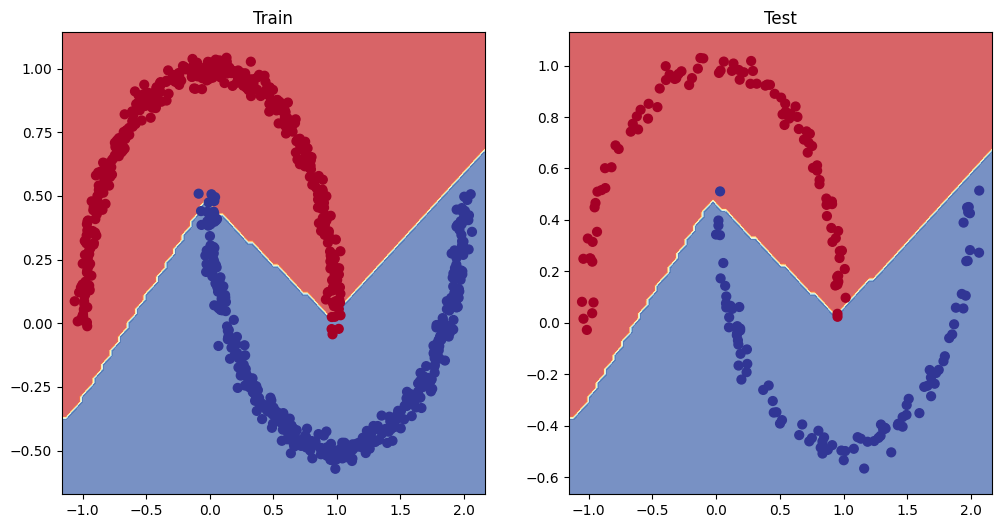

In [70]:
import matplotlib.pyplot as plt

# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

Create a multi-class dataset using the spirals data creation function from CS231n (see below for the code).

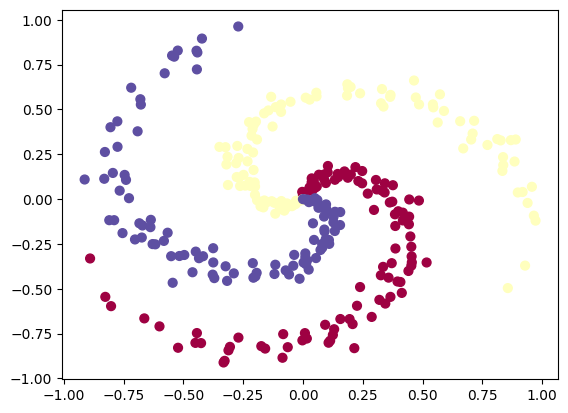

In [71]:
# Code for creating a spiral dataset from CS231n
import numpy as np
N = 100 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X = np.zeros((N*K,D)) # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8') # class labels
for j in range(K):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N) # radius
  t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
  X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y[ix] = j
# lets visualize the data
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.show()


In [83]:
# Set random seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

#Moving data to selected device
X_train = torch.from_numpy(X_train).float().to(device)
X_test = torch.from_numpy(X_test).float().to(device)
y_train = torch.from_numpy(y_train).long().to(device)
y_test = torch.from_numpy(y_test).long().to(device)



In [84]:
#Building multiclassmosel
class MultiClassSpiralModel(nn.Module):
    def __init__(self):
        super(MultiClassSpiralModel, self).__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.relu = nn.ReLU()
        self.layer_2 = nn.Linear(in_features=10, out_features=3)

    def forward(self, x):
        x = self.relu(self.layer_1(x))
        x = self.layer_2(x)
        return x

# Instantiate the model and move to device
model = MultiClassSpiralModel().to(device)



In [85]:
import torch.optim as optim
# Setting loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [79]:
!pip install torchmetrics

from torchmetrics.classification import Accuracy

# Define the number of classes for the multiclass task
num_classes = 3

# Create the accuracy function and send it to the device
acc_fn = Accuracy(num_classes=num_classes, task='multiclass').to(device)

# Display the accuracy function
print(acc_fn)


MulticlassAccuracy()


In [88]:
# Build a training loop for the model
epochs = 1000

# Create a progress bar using tqdm
for epoch in range(epochs):
    ## Training
    model_1.train()
    # 1. Forward pass
    y_logits = model(X_train)
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

    # 2. Calculate the loss
    loss = loss_fn(y_logits, y_train)
    acc = acc_fn(y_pred, y_train)

    # 3. Zero the optimizer gradients
    optimizer.zero_grad()

    # 4. Backward pass and update weights
    loss.backward()
    optimizer.step()

    ## Testing
    model_1.eval()
    with torch.inference_mode():
        # 1. Forward pass for testing
        test_logits = model(X_test)
        test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
        # 2. Calculate test loss and accuracy
        test_loss = loss_fn(test_logits, y_test)
        test_acc = acc_fn(test_pred, y_test)

    # Print out progress
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.2f} Acc: {acc:.2f} | Test loss: {test_loss:.2f} Test acc: {test_acc:.2f}")


Epoch: 0 | Loss: 1.09 Acc: 0.49 | Test loss: 1.09 Test acc: 0.38
Epoch: 100 | Loss: 0.68 Acc: 0.60 | Test loss: 0.71 Test acc: 0.50
Epoch: 200 | Loss: 0.53 Acc: 0.72 | Test loss: 0.51 Test acc: 0.73
Epoch: 300 | Loss: 0.36 Acc: 0.83 | Test loss: 0.35 Test acc: 0.78
Epoch: 400 | Loss: 0.28 Acc: 0.88 | Test loss: 0.27 Test acc: 0.87
Epoch: 500 | Loss: 0.23 Acc: 0.91 | Test loss: 0.23 Test acc: 0.88
Epoch: 600 | Loss: 0.20 Acc: 0.93 | Test loss: 0.21 Test acc: 0.88
Epoch: 700 | Loss: 0.18 Acc: 0.93 | Test loss: 0.19 Test acc: 0.90
Epoch: 800 | Loss: 0.17 Acc: 0.93 | Test loss: 0.18 Test acc: 0.90
Epoch: 900 | Loss: 0.16 Acc: 0.94 | Test loss: 0.17 Test acc: 0.90


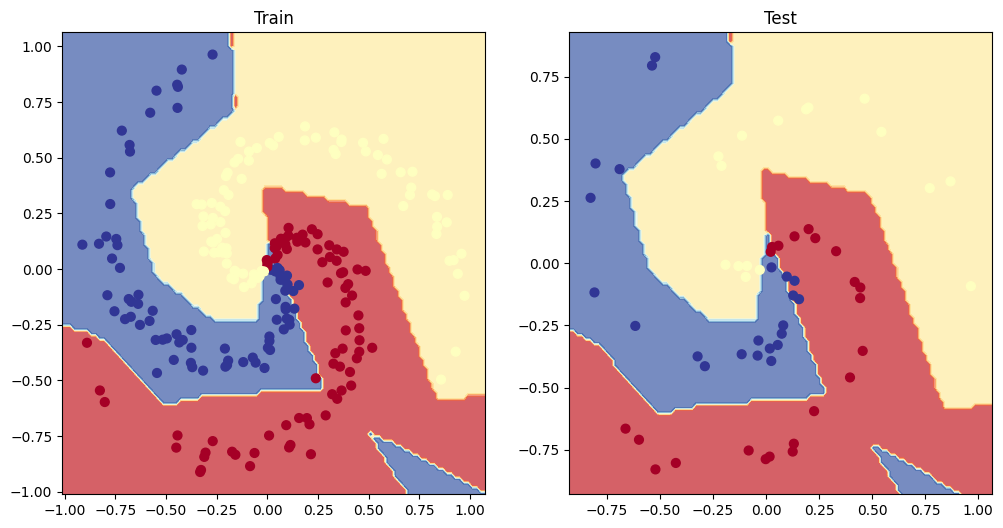

In [89]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model, X_test, y_test)